In [4]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe

In [5]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(42)

## Puxada dos dados modelados do processo de extração

In [6]:
modelo_inventario = rfe.read_file('etl_results/tempo_em_estoque.xlsx').get_df()
modelo_transac_prod = rfe.read_file('etl_results/transacoes_produto_tratado_final.xlsx').get_df()

## Dados de Inventário

In [7]:
modelo_inventario


codigo                                 descricao  categoria  estoque_disponivel  preco             incluido_em             alterado_em   ncm  taxa_depreciacao  ano_mes        mes   indice  te_inicio_presente  te_atualizacao_presente  te_inicio_atualizacao  anos_estoque                  clf_estoque  fator_atualizacao  depreciacao_unit  fator_correcao  correcao_unit  correcao_deprec  depreciacao  valor_ini  valor_estoque_deprec  valor_estoque_depreciado_corrigido
0     7100692                APLIQUE - APM4 -053 NOIVOS  papelaria                 9.0    2.5 2020-11-16 17:19:42.000 2021-04-13 15:15:27.708  3926                 0  2021-04 2021-04-01  5692.31                 620                      472                    147      1.292292           Produto no estoque           0.761290          0.000000        1.126423       2.816058         2.816058     0.000000       22.5              0.000000                            0.000000
1      099939  MASSA BISCUIT acrilex 90G - AMARELO PELE  papelaria                 0.0    4.5 2020-03-12 09:25:38.569 2021-04-13 14:54:44.957  3926                 0  2021-04 2021-04-01  5692.31                 870                      472                    397      1.292292  Produto não está em estoque           1.000000          0.000000        1.126423       5.068904         5.068904     0.000000        0.0              0.000000                            0.000000
2      099935   MASSA BISCUIT acrilex 90G - VERDE MUSGO  papelaria                 0.0    4.5 2020-03-12 09:11:30.999 2021-04-13 14:55:19.701  3926                 0  2021-04 2021-04-01  5692.31                 870                      472                    397      1.292292  Produto não está em estoque           1.000000          0.000000        1.126423       5.068904         5.068904     0.000000        0.0              0.000000                            0.000000
3      099993                     PINCEL TIGRE 815 - 04  papelaria                 3.0    3.5 2020-03-12 16:23:51.521 2021-04-30 17:10:25.288  3926                 0  2021-04 2021-04-01  5692.31                 869                      455                    414      1.245748           Produto no estoque           0.523590          0.000000        1.126423       3.942481         3.942481     0.000000       10.5              0.000000                            0.000000
4      099996                     PINCEL TIGRE 815 - 10  papelaria                 4.0    5.0 2020-03-12 16:28:07.014 2021-04-30 17:11:11.816  3926                 0  2021-04 2021-04-01  5692.31                 869                      455                    414      1.245748           Produto no estoque           0.523590          0.000000        1.126423       5.632116         5.632116     0.000000       20.0              0.000000                            0.000000
...       ...                                       ...        ...                 ...    ...                     ...                     ...   ...               ...      ...        ...      ...                 ...                      ...                    ...           ...                          ...                ...               ...             ...            ...              ...          ...        ...                   ...                                 ...
5116  7100714             PANO DE COPA NATAL PAPAI NOEL    enxoval                 0.0    9.5 2020-11-24 10:09:39.995 2022-01-15 10:33:43.065  6303                20  2022-01 2022-01-01  6153.09                 613                      196                    417      0.536630  Produto não está em estoque           1.000000          0.000000        1.042070       9.899664         5.894360     0.000000        0.0              0.000000                            0.000000
5117   099804                                  TNT AZUL     tecido                 4.0    2.0 2020-03-07 08:19:00.682 2020-04-29 14:49:39.436  6303                20  2020-04 2020-04-01  5331.91                 875         

In [8]:
modelo_transac_prod 

tipo  numero                    data                    hora                        produto  quant_  vl__unitario  sub_total  desconto  outras_despesas gerado_clf_auto  total    codigo  categoria
0          Ajuste de Custo   38041 2022-07-20 17:40:01.564 2022-07-20 17:40:01.564  LINHA CLÉA 125 -5899 PANTANAL     0.0          9.25        0.0       0.0                0               S    0.0  85922412      linha
1      Ajuste de Estoque +   38040 2022-07-20 17:40:01.374 2022-07-20 17:40:01.374  LINHA CLÉA 125 -5899 PANTANAL    10.0          0.00        0.0       0.0                0               S    0.0  15042603      linha
2          Ajuste de Custo   36992 2022-06-16 10:35:44.146 2022-06-16 10:35:44.146       AGULHA CROCHE LULI - 5,5     0.0          3.00        0.0       0.0                0               S    0.0   3456886  armarinho
3      Ajuste de Estoque +   36991 2022-06-16 10:35:43.968 2022-06-16 10:35:43.968       AGULHA CROCHE LULI - 5,5    12.0          0.00        0.0       0.0                0               S    0.0  99629223  armarinho
4                    Venda   36767 2022-06-09 10:42:36.640 2022-06-09 10:42:36.640        PAPEL DECOUPAGE-AFQ-032    -1.0          3.00        3.0       0.0                0               S    3.0  37013810  papelaria
...                    ...     ...                     ...                     ...                            ...     ...           ...        ...       ...              ...             ...    ...       ...        ...
47447  Ajuste de Estoque +       7 2020-02-03 13:31:23.044 2020-02-03 13:31:23.044            Linha Rayza - Cinza     9.0          0.00        0.0       0.0                0               N    0.0     98012      linha
47448      Ajuste de Custo       6 2020-02-03 13:29:52.455 2020-02-03 13:29:52.455          Linha Rayza - Laranja     0.0          5.50        0.0       0.0                0               N    0.0     98033      linha
47449  Ajuste de Estoque +       5 2020-02-03 13:29:52.440 2020-02-03 13:29:52.440          Linha Rayza - Laranja     5.0          0.00        0.0       0.0                0               N    0.0     98033      linha
47450      Ajuste de Custo       4 2020-02-03 13:27:48.967 2020-02-03 13:27:48.967   Linha Rayza - Verde Bandeira     0.0          5.50        0.0       0.0                0               N    0.0     98043      linha
47451  Ajuste de Estoque +       3 2020-02-03 13:27:48.958 2020-02-03 13:27:48.958   Linha Rayza - Verde Bandeira     9.0          0.00        0.0       0.0                0               N    0.0     98043      linha

[47452 rows x 14 columns]

<Figure size 640x480 with 0 Axes>

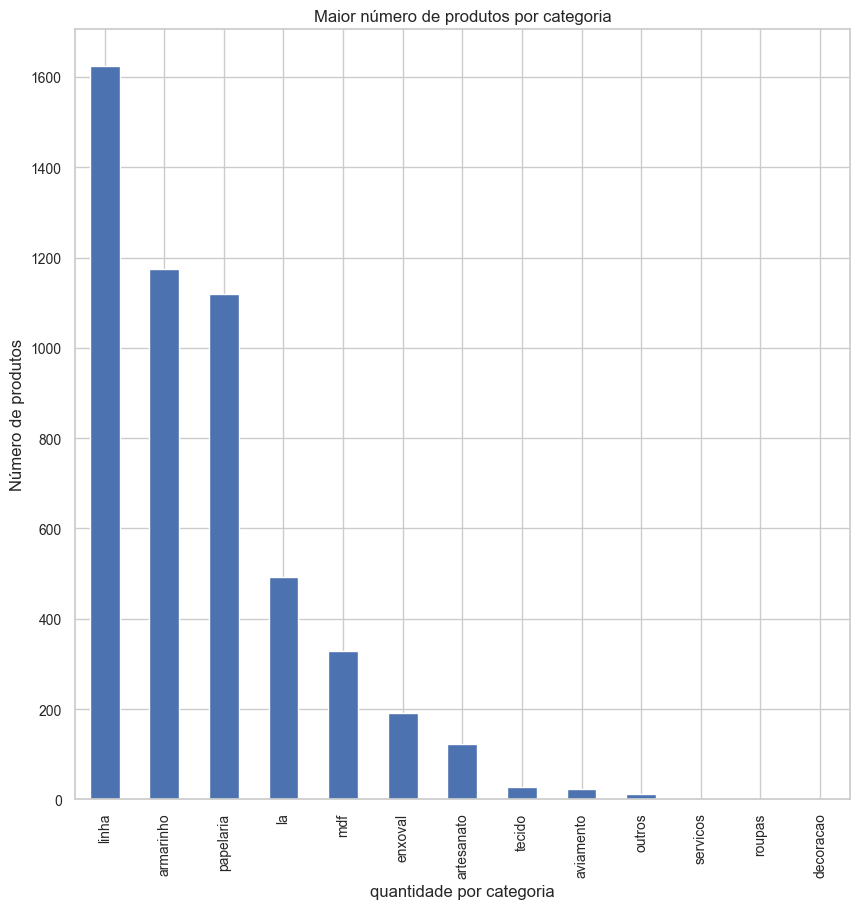

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


plot_rank_categoria = modelo_inventario['categoria'].value_counts().plot(kind='bar', title='Maior número de produtos por categoria',figsize=(10,10))
plot_rank_categoria.set_xlabel('quantidade por categoria')
plot_rank_categoria.set_ylabel('Número de produtos')
plt.show()

In [10]:
classificacao_inv = modelo_inventario.groupby('clf_estoque').agg({'categoria': 'nunique', 'codigo': 'count'})
classificacao_inv.head()

categoria  codigo
clf_estoque                                            
Produto alterado no último trimestre         10     186
Produto no estoque                            9    3130
Produto não está em estoque                  12     927
Risco de estoque parado                      10     878

<Figure size 640x480 with 0 Axes>

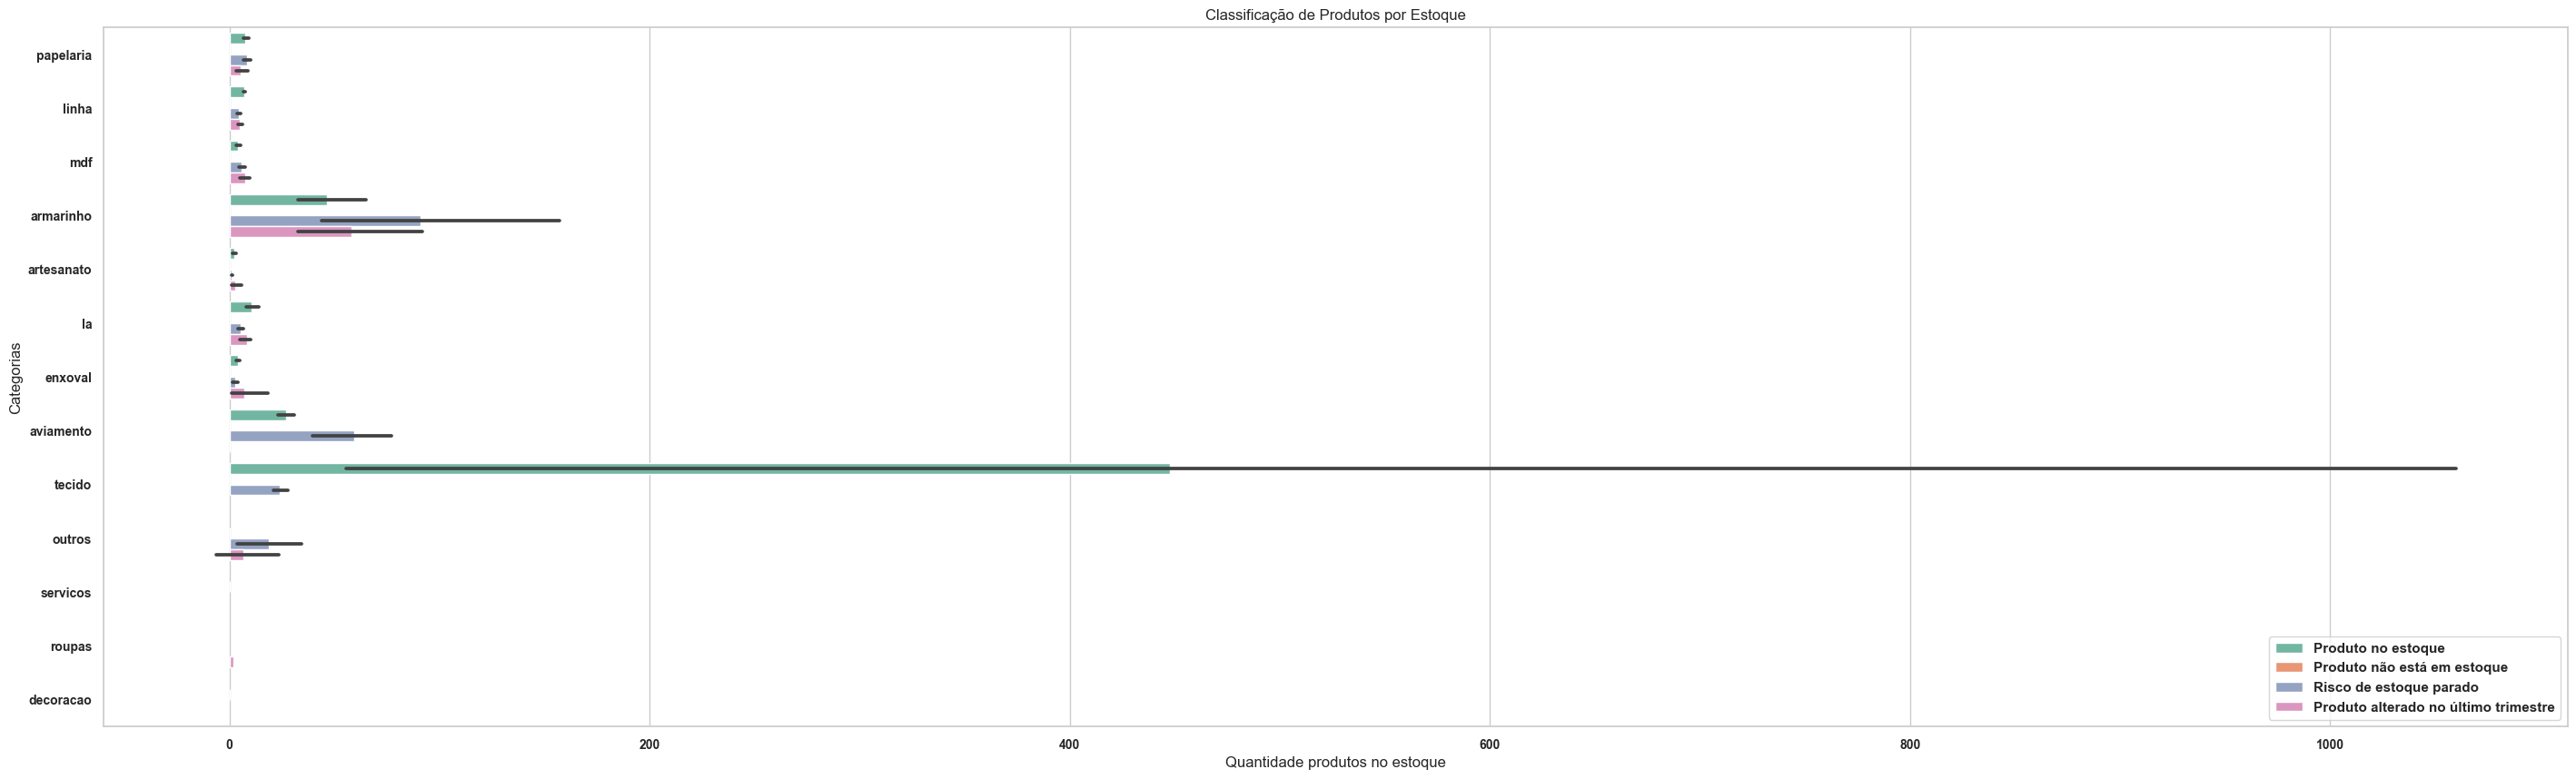

<Figure size 2000x2000 with 0 Axes>

In [11]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,10)
plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

#plot by clf_estoque from tempo_em_estoque

plot_classificacao_inv = sns.barplot(x='estoque_disponivel', y='categoria', data=modelo_inventario, hue='clf_estoque', palette='Set2', ax=ax)
plot_classificacao_inv.set_xlabel('Quantidade produtos no estoque')
plot_classificacao_inv.set_ylabel('Categorias')
plot_classificacao_inv.set_title('Classificação de Produtos por Estoque')
plot_classificacao_inv.legend(loc='lower right')
plt.figure(figsize=(20,20))
plt.show()

In [12]:
tempo_em_estoque_parado = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado']
agrupamento_clf = tempo_em_estoque_parado.groupby(['categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean'})
agrupamento_clf

codigo      preco  estoque_disponivel
categoria                                        
armarinho      170   8.248882           90.878353
artesanato      16  92.062500            1.250000
aviamento       18   5.138889           59.472222
enxoval         23  56.260870            2.652174
la              18  32.600000            5.388889
linha           47  38.385106            4.595745
mdf            126  16.509127            5.801587
outros           4  17.325000           18.625000
papelaria      452   5.823230            8.265487
tecido           4  11.825000           24.000000

Será considerado uma análise dos itens classificados como "Risco de estoque parado".

In [13]:
agrupamento_risco = modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado'].groupby(['clf_estoque','categoria']).agg({'codigo': 'count','preco': 'mean','estoque_disponivel': 'mean','te_inicio_presente': 'mean','te_atualizacao_presente': 'mean','te_inicio_atualizacao': 'mean','fator_atualizacao': 'mean','depreciacao': 'mean'})
for index, row in agrupamento_risco.iterrows():
    agrupamento_risco = agrupamento_risco.drop(index)
    

<Figure size 40x30 with 0 Axes>

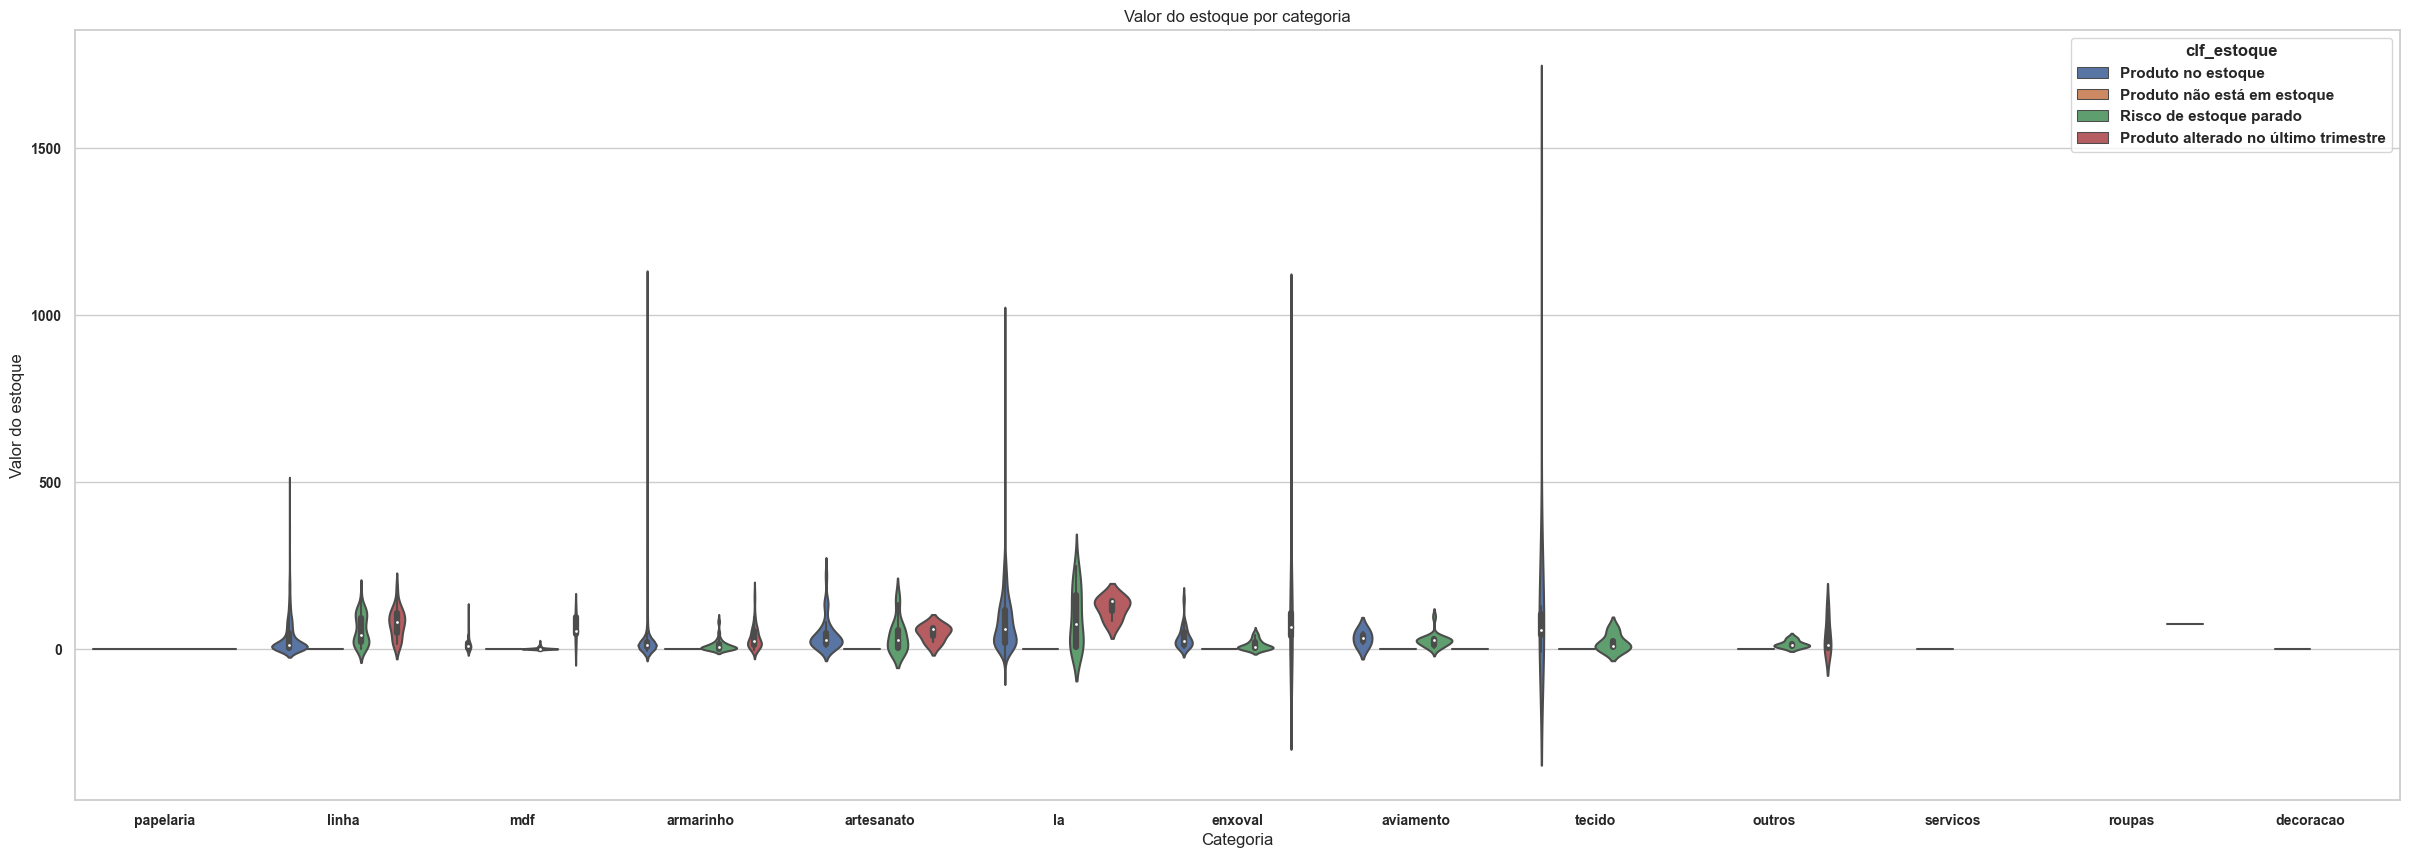

<Figure size 2000x2000 with 0 Axes>

In [14]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=5)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots()

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

b=sns.violinplot(x = 'categoria',y='valor_estoque_depreciado_corrigido', data=modelo_inventario, hue='clf_estoque')
b.set_xlabel('Categoria')
b.set_ylabel('Valor do estoque')
b.set_title('Valor do estoque por categoria')
plt.figure(figsize=(20,20))
plot_classificacao_inv.legend(loc='upper left')
plt.show()


In [15]:
#Rank de produtos em estoque por categoria com risco de estarem parados
top_10_fator_atualizacao_2 = modelo_inventario[modelo_inventario['fator_atualizacao'] == 1]
top_10_fator_atualizacao_2 = top_10_fator_atualizacao_2.sort_values(by=['fator_atualizacao'], ascending=False).groupby('clf_estoque')

top_10_fator_atualizacao_2[['categoria','descricao','estoque_disponivel','te_inicio_atualizacao','fator_atualizacao']].head(50)


categoria                                 descricao  estoque_disponivel  te_inicio_atualizacao  fator_atualizacao
1     papelaria  MASSA BISCUIT acrilex 90G - AMARELO PELE                 0.0                    397                1.0
2958      linha               BARBANTE TRENTO - CINZA 270                 0.0                    795                1.0
2754  armarinho               AGULHA CROCHÊ CIRCULO - 3,5                 0.0                    710                1.0
2753  armarinho                 AGULHA CROCHÊ CIRCULO - 3                 0.0                    710                1.0
2745  armarinho              AGULHA CROCHÊ  MILWARD 5,5mm                 0.0                      0                1.0
...         ...                                       ...                 ...                    ...                ...
1746  armarinho           RENDA GUIPEARE CHL 589 VERMELHO                13.7                      0                1.0
1745  armarinho           RENDA GUIPEARE CHL 589 ROSA 5CM                17.0                      0                1.0
1744  armarinho              RENDA GUIPEARE CHL 589 PRETA                27.4                      0                1.0
1743  armarinho            RENDA GUIPEARE CHL - 438 PRETA                13.7                      0                1.0
1742  armarinho                  RENDA GUIPEARE 9CM PRETO                 3.0                      0                1.0

[100 rows x 5 columns]

In [16]:
#g = sns.PairGrid(modelo_inventario, hue="categoria")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [17]:
#g = sns.PairGrid(modelo_inventario, hue="clf_estoque")
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [18]:
#g = sns.PairGrid(modelo_inventario[modelo_inventario['clf_estoque'] == 'Risco de estoque parado'], hue='categoria')
#g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
#g.add_legend()

In [19]:
corr = modelo_inventario.corr()
corr.style.background_gradient(cmap='coolwarm')



Devido à baixa correlação presente na massa de dados, O trabalho passa a considerar os dados de Transação de produtos para a análise do modelo.



## DataFrame de Produtos

In [20]:
tipo_transf = modelo_transac_prod.tipo.unique()
tipo_transf

array(['Ajuste de Custo', 'Ajuste de Estoque +', 'Venda',
       'Ajuste de Estoque -', 'Devolução do Cliente'], dtype=object)

In [21]:
modelo_transac_prod['tipo'].value_counts()

Venda                   19997
Ajuste de Custo         13501
Ajuste de Estoque +      8984
Ajuste de Estoque -      4967
Devolução do Cliente        3
Name: tipo, dtype: int64

### Dados de Venda

In [22]:
modelo_transac_prod_vendas = modelo_transac_prod[modelo_transac_prod['tipo'] == 'Venda']
modelo_transac_prod_vendas['quant_'] = modelo_transac_prod_vendas['quant_']*-1
modelo_transac_prod_vendas


tipo  numero                    data                    hora                         produto  quant_  vl__unitario  sub_total  desconto  outras_despesas gerado_clf_auto  total          codigo  categoria
4      Venda   36767 2022-06-09 10:42:36.640 2022-06-09 10:42:36.640         PAPEL DECOUPAGE-AFQ-032     1.0           3.0        3.0      0.00                0               S   3.00        37013810  papelaria
5      Venda   36547 2022-06-03 09:31:31.703 2022-06-03 09:31:31.703             BASTIDOR MDF - 18CM     1.0           8.5        8.5      0.00                0               S   8.50        32968828        mdf
6      Venda   36426 2022-05-30 16:24:04.069 2022-05-30 16:24:04.069       FRALDA BOCA NICOLI - ROSA     2.0           4.8        9.6      0.00                0               S   9.60        30058838    enxoval
7      Venda   36392 2022-05-28 10:42:32.680 2022-05-28 10:42:32.680  AGULHA CROCHÊ ESMALTADA - 2,5M     1.0           7.0        7.0      0.22                0               S   6.78        18828463  armarinho
8      Venda   36367 2022-05-27 14:08:31.247 2022-05-27 14:08:31.247    AGULHA CROCHÊ MILWARD 5,5 mm     1.0           7.0        7.0      0.69                0               S   6.31        98947493  armarinho
...      ...     ...                     ...                     ...                             ...     ...           ...        ...       ...              ...             ...    ...             ...        ...
36476  Venda   11638 2020-09-13 16:46:32.133 2020-09-13 16:46:32.133             Linha Rayza - Lilás     2.0           8.5       17.0      0.00                0               N  17.00           98006      linha
36477  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784            COSTURA DRIMA - 6104     1.0           2.0        2.0      0.00                0               N   2.00         7099730      linha
36478  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784            COSTURA DRIMA - 5878     1.0           2.0        2.0      0.00                0               N   2.00  N126100-005876      linha
36479  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784              COSTURA DRIMA - PT     1.0           2.0        2.0      0.00                0               N   2.00          098930      linha
36480  Venda   11637 2020-09-13 16:45:49.784 2020-09-13 16:45:49.784          COSTURA DRIMA - Branca     1.0           2.0        2.0      0.00                0               N   2.00   N126100-0000B      linha

[19997 rows x 14 columns]

In [23]:
modelo_transac_prod_vendas = modelo_transac_prod_vendas.groupby(['numero','categoria','data']).agg({'quant_': 'sum','total':'sum'}).reset_index()
modelo_transac_prod_vendas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12172 entries, 0 to 12171
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   numero     12172 non-null  int64         
 1   categoria  12172 non-null  object        
 2   data       12172 non-null  datetime64[ns]
 3   quant_     12172 non-null  float64       
 4   total      12172 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 475.6+ KB


In [24]:
#modelo_transac_prod_vendas normalize quant_ field
modelo_transac_prod_vendas['qtd_norm'] = (modelo_transac_prod_vendas['quant_'] - modelo_transac_prod_vendas['quant_'].min())/ (modelo_transac_prod_vendas['quant_'].max() - modelo_transac_prod_vendas['quant_'].min())
modelo_transac_prod_vendas['data_dia'] = modelo_transac_prod_vendas['data'].dt.date
modelo_transac_prod_vendas['ano'] = modelo_transac_prod_vendas['data'].dt.year
modelo_transac_prod_vendas['mes'] = modelo_transac_prod_vendas['data'].dt.month
modelo_transac_prod_vendas['mes_ano'] = modelo_transac_prod_vendas['data_dia'].astype(str).str[0:7]
modelo_transac_prod_vendas

numero  categoria                    data  quant_  total  qtd_norm    data_dia   ano  mes  mes_ano
0       11637      linha 2020-09-13 16:45:49.784    4.00   8.00  0.003988  2020-09-13  2020    9  2020-09
1       11638      linha 2020-09-13 16:46:32.133    2.00  17.00  0.001988  2020-09-13  2020    9  2020-09
2       11639      linha 2020-09-13 16:47:04.101    1.00   8.50  0.000988  2020-09-13  2020    9  2020-09
3       11640      linha 2020-09-13 16:47:59.107    4.00  34.00  0.003988  2020-09-13  2020    9  2020-09
4       11641      linha 2020-09-13 16:50:17.444    1.00  12.90  0.000988  2020-09-13  2020    9  2020-09
...       ...        ...                     ...     ...    ...       ...         ...   ...  ...      ...
12167   38248  papelaria 2022-07-29 17:29:13.607    1.00  16.80  0.000988  2022-07-29  2022    7  2022-07
12168   38251  armarinho 2022-07-30 09:36:37.140    1.00   5.80  0.000988  2022-07-30  2022    7  2022-07
12169   38251      linha 2022-07-30 09:36:37.140    2.00   6.00  0.001988  2022-07-30  2022    7  2022-07
12170   38252  armarinho 2022-07-30 09:45:20.596  100.00  28.00  0.099989  2022-07-30  2022    7  2022-07
12171   38253     tecido 2022-07-30 11:45:35.193    0.25   6.97  0.000238  2022-07-30  2022    7  2022-07

[12172 rows x 10 columns]

In [25]:
#ajustando o campo data para o formato datetime para poder fazer o agrupamento
modelo_transac_prod_vendas_diario = modelo_transac_prod_vendas[['numero','categoria','data_dia','ano','mes','mes_ano','quant_','qtd_norm','total']].sort_values(by=['data_dia'], ascending=True)

## Estacionaridade 


In [26]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    dftest2 = adfuller(ts.diff().dropna())
    dftest3 = adfuller(ts.diff().diff().dropna())
    adf = dftest[0]
    adf2 = dftest2[0]
    adf3 = dftest3[0]
    pvvalue = dftest[1]
    pvvalue2 = dftest2[1]
    pvvalue3 = dftest3[1]
    critical_value = dftest[4]
    critical_value2 = dftest2[4]
    critical_value3 = dftest3[4]
    print('Results of Dickey-Fuller Test:')
    print('Test Statistic: ', adf)
    print('p-value: ', pvvalue)
    print('Critical Values: ', critical_value)
    if pvvalue < 0.05 and adf < critical_value['1%']:
        print('Stationary')
    else:
        print('Not Stationary')

    print('Results of Dickey-Fuller Test 2:')
    print('Test Statistic: ', adf2)
    print('p-value: ', pvvalue2)
    print('Critical Values: ', critical_value2)
    if pvvalue2 < 0.05 and adf2 < critical_value2['1%']:
        print('Stationary')
    else:
        print('Not Stationary')

    print('Results of Dickey-Fuller Test 3:')
    print('Test Statistic: ', adf3)
    print('p-value: ', pvvalue3)
    print('Critical Values: ', critical_value3)
    if pvvalue3 < 0.05 and adf3 < critical_value3['1%']:
        print('Stationary')
    else:
        print('Not Stationary')
        
    return adf, adf2, adf3, pvvalue, pvvalue2, pvvalue3, critical_value, critical_value2, critical_value3
        
#    pvalue = dftest[1]
#   critical_value = dftest[4]['5%']
#   if (pvalue < 0.05) and (adf < critical_value):
#       print('The series is stationary')
#       print('ADF Statistic: %f' % dftest[0])
#       print('p-value: %f' % dftest[1])
#       print('Critical Values:')
#       for key, value in dftest[4].items():
#           print('\t%s: %.3f' % (key, value))
#
#   else:
#       print('The series is NOT stationary')
#       print('ADF Statistic: %f' % dftest[0])
#       print('p-value: %f' % dftest[1])
#       print('Critical Values:')
#       for key, value in dftest[4].items():
#           print('\t%s: %.3f' % (key, value))
#   


            

linha
Results of Dickey-Fuller Test:
Test Statistic:  -29.49674814376636
p-value:  0.0
Critical Values:  {'1%': -3.4319320510527267, '5%': -2.862239063354696, '10%': -2.567142117784963}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -19.824370048401555
p-value:  0.0
Critical Values:  {'1%': -3.431943229091185, '5%': -2.8622440012896564, '10%': -2.5671447465191686}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -24.410293364582373
p-value:  0.0
Critical Values:  {'1%': -3.431943617358793, '5%': -2.8622441728078063, '10%': -2.567144837827764}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -29.49674814376636
p-value:  0.0
Critical Values:  {'1%': -3.4319320510527267, '5%': -2.862239063354696, '10%': -2.567142117784963}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -19.824370048401555
p-value:  0.0
Critical Values:  {'1%': -3.431943229091185, '5%': -2.8622440012896564, '10%': -2.5671447465191686}
Stationary
Results of Dickey-Fuller Tes

<Figure size 640x400 with 0 Axes>

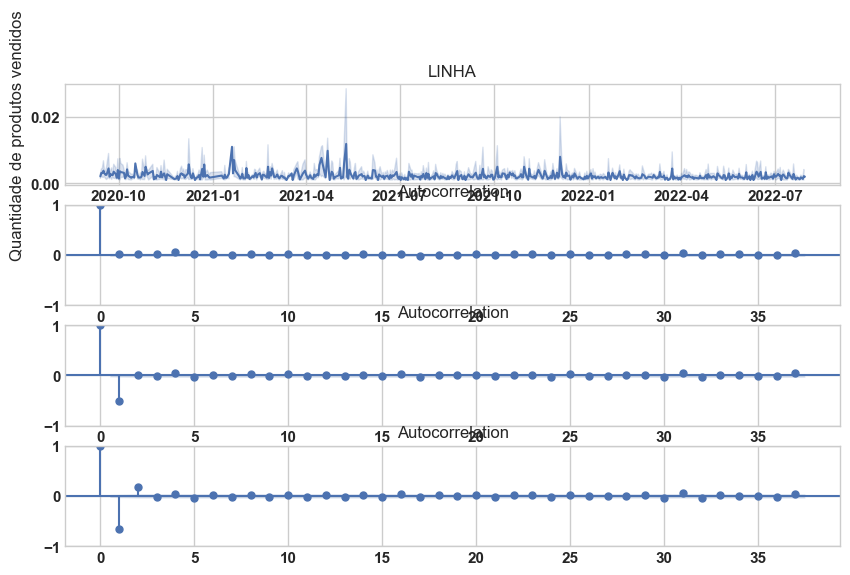

tecido
Results of Dickey-Fuller Test:
Test Statistic:  -4.47791199699092
p-value:  0.0002155226280312727
Critical Values:  {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -8.255435401494282
p-value:  5.252753534453952e-13
Critical Values:  {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -8.33706367695063
p-value:  3.250810062903577e-13
Critical Values:  {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -4.47791199699092
p-value:  0.0002155226280312727
Critical Values:  {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -8.255435401494282
p-value:  5.252753534453952e-13
Critical Values:  {'1%': -3.4566744514553016, '5%

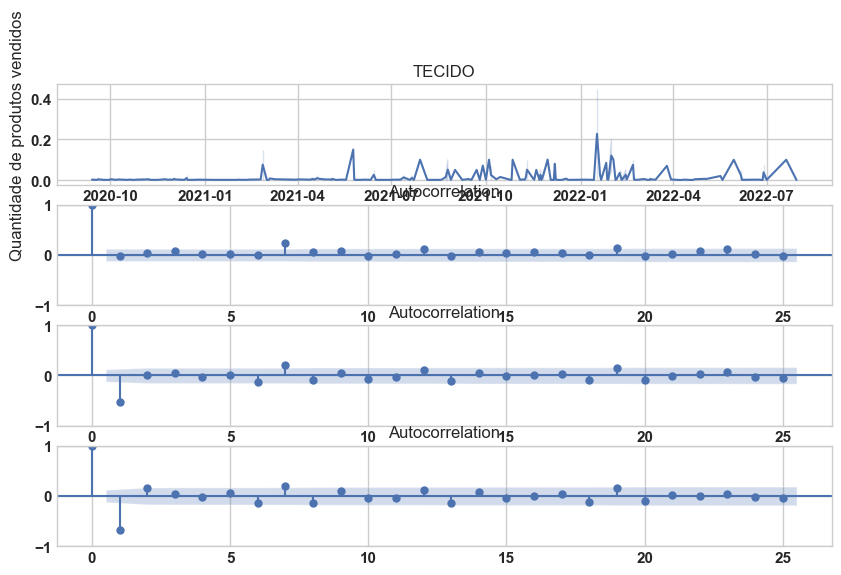

armarinho
Results of Dickey-Fuller Test:
Test Statistic:  -11.764637556453977
p-value:  1.1266058334888252e-21
Critical Values:  {'1%': -3.4320903643564535, '5%': -2.862308997046807, '10%': -2.567179347626188}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -18.275228657359083
p-value:  2.3148257008642186e-30
Critical Values:  {'1%': -3.432095940317471, '5%': -2.862311460117259, '10%': -2.567180658875769}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -23.84921932070937
p-value:  0.0
Critical Values:  {'1%': -3.432097339894967, '5%': -2.862312078352202, '10%': -2.567180988001804}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -11.764637556453977
p-value:  1.1266058334888252e-21
Critical Values:  {'1%': -3.4320903643564535, '5%': -2.862308997046807, '10%': -2.567179347626188}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -18.275228657359083
p-value:  2.3148257008642186e-30
Critical Values:  {'1%': -3.432095940317471, '5%': -2.8623114

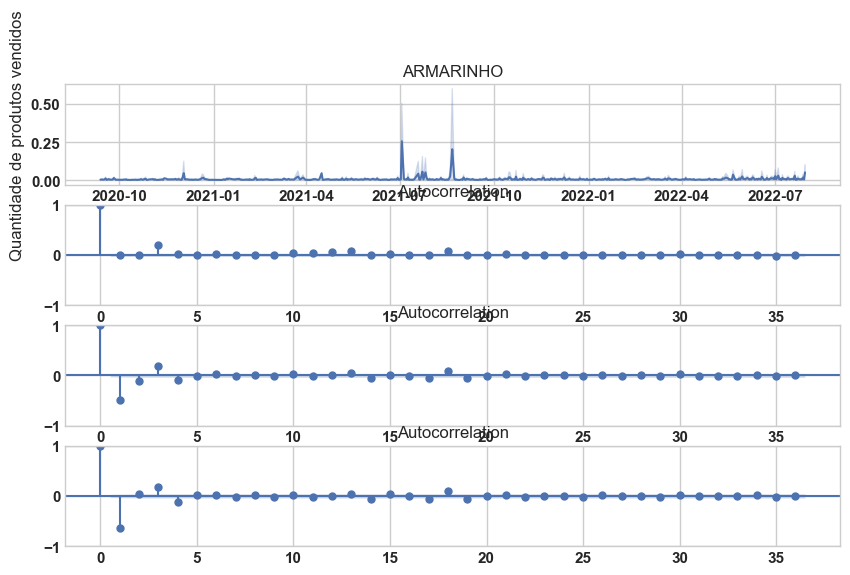

papelaria
Results of Dickey-Fuller Test:
Test Statistic:  -4.926776302215588
p-value:  3.0922042025458335e-05
Critical Values:  {'1%': -3.434659459080052, '5%': -2.8634433571425317, '10%': -2.567783321069945}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -16.133391212464833
p-value:  4.7591189088828196e-29
Critical Values:  {'1%': -3.4346623009329513, '5%': -2.8634446113978034, '10%': -2.5677839889683494}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -18.869061656906133
p-value:  0.0
Critical Values:  {'1%': -3.4346737059247014, '5%': -2.8634496449929934, '10%': -2.567786669389711}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -4.926776302215588
p-value:  3.0922042025458335e-05
Critical Values:  {'1%': -3.434659459080052, '5%': -2.8634433571425317, '10%': -2.567783321069945}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -16.133391212464833
p-value:  4.7591189088828196e-29
Critical Values:  {'1%': -3.4346623009329513, '5%': -2.86

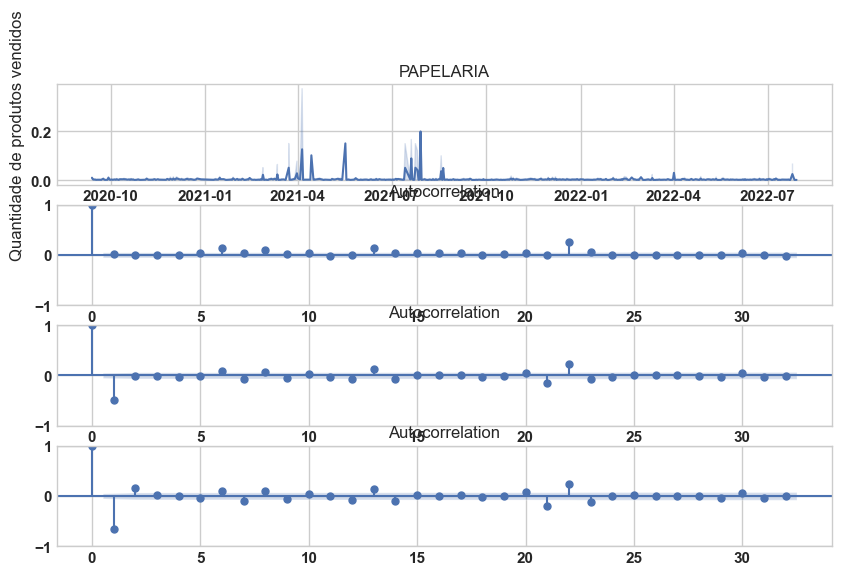

artesanato
Results of Dickey-Fuller Test:
Test Statistic:  -6.157494444659796
p-value:  7.308417097574886e-08
Critical Values:  {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -6.468437265908918
p-value:  1.38638482972841e-08
Critical Values:  {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -7.343812998776217
p-value:  1.0482841590182699e-10
Critical Values:  {'1%': -3.4782936965183815, '5%': -2.882567574015525, '10%': -2.5779830117488745}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -6.157494444659796
p-value:  7.308417097574886e-08
Critical Values:  {'1%': -3.473829775724492, '5%': -2.880622899711496, '10%': -2.5769448985432954}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -6.468437265908918
p-value:  1.38638482972841e-08
Critical Values:  {'1%': -3.4769274060112707, '

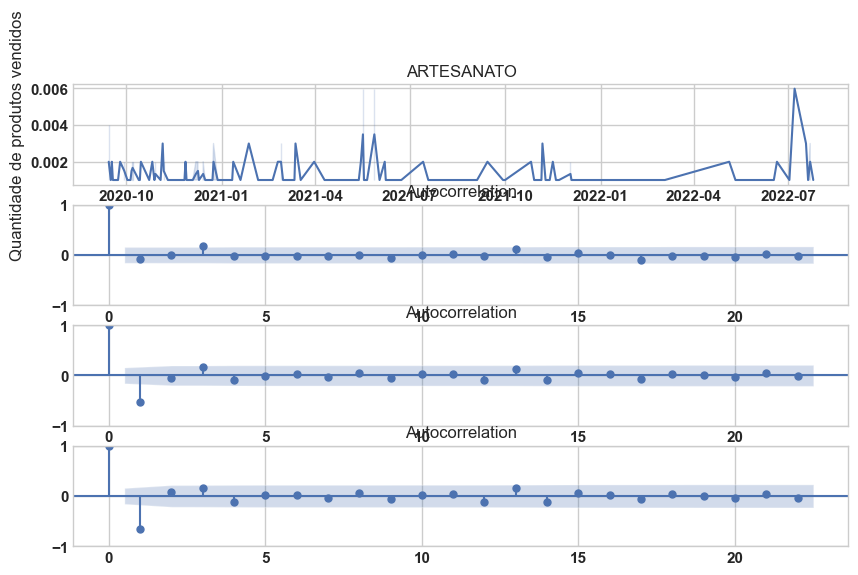

mdf
Results of Dickey-Fuller Test:
Test Statistic:  -6.09114913965117
p-value:  1.0357514014256873e-07
Critical Values:  {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -7.632224650026528
p-value:  1.9948409559689866e-11
Critical Values:  {'1%': -3.4538376962008495, '5%': -2.8718811911083093, '10%': -2.5722803076202174}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -8.128814577017343
p-value:  1.1044064888647712e-12
Critical Values:  {'1%': -3.4540076534999957, '5%': -2.8719557347997178, '10%': -2.5723200648758366}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -6.09114913965117
p-value:  1.0357514014256873e-07
Critical Values:  {'1%': -3.4529449243622383, '5%': -2.871489553425686, '10%': -2.572071437887033}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -7.632224650026528
p-value:  1.9948409559689866e-11
Critical Values:  {'1%': -3.4538376962008495, '5

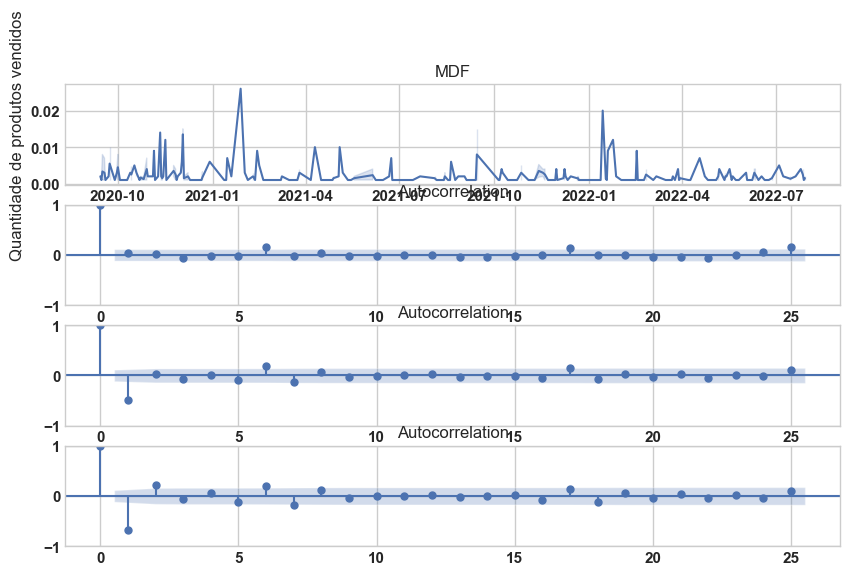

enxoval
Results of Dickey-Fuller Test:
Test Statistic:  -7.2583164006273515
p-value:  1.7075847674988137e-10
Critical Values:  {'1%': -3.4447721346720885, '5%': -2.8678991615065095, '10%': -2.570157193174823}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -9.260132542710586
p-value:  1.4144115284568044e-15
Critical Values:  {'1%': -3.4451307246616514, '5%': -2.86805689169311, '10%': -2.570241263729327}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -10.82668585109367
p-value:  1.7496524533794202e-19
Critical Values:  {'1%': -3.445231637930579, '5%': -2.8681012763264233, '10%': -2.5702649212751583}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -7.2583164006273515
p-value:  1.7075847674988137e-10
Critical Values:  {'1%': -3.4447721346720885, '5%': -2.8678991615065095, '10%': -2.570157193174823}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -9.260132542710586
p-value:  1.4144115284568044e-15
Critical Values:  {'1%': -3.44513072466165

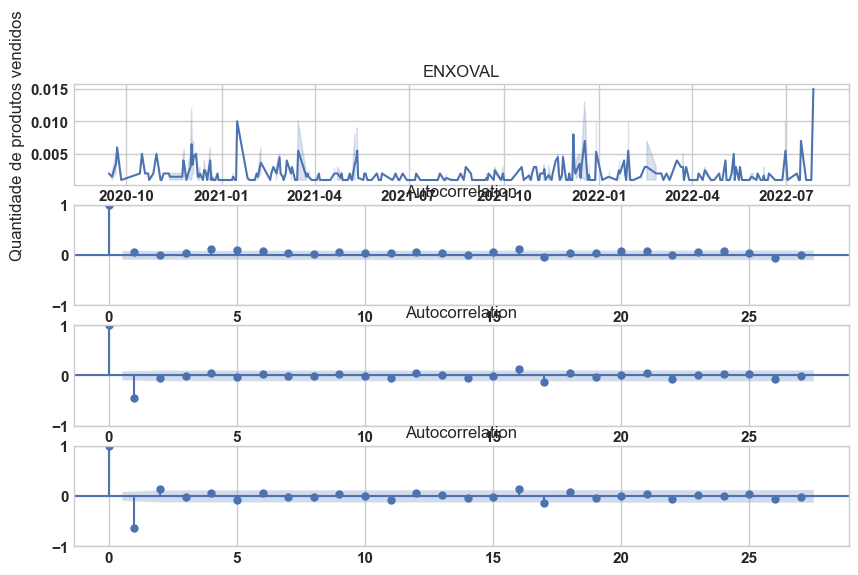

la
Results of Dickey-Fuller Test:
Test Statistic:  -36.78520696012842
p-value:  0.0
Critical Values:  {'1%': -3.4347941822385923, '5%': -2.863502816068378, '10%': -2.5678149835134185}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -13.640939876350927
p-value:  1.6536231196727088e-25
Critical Values:  {'1%': -3.4348554210983093, '5%': -2.8635298424390276, '10%': -2.5678293754552732}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -16.063141216749838
p-value:  5.61053165730168e-29
Critical Values:  {'1%': -3.434874123222469, '5%': -2.8635380960841084, '10%': -2.5678337706609993}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -36.78520696012842
p-value:  0.0
Critical Values:  {'1%': -3.4347941822385923, '5%': -2.863502816068378, '10%': -2.5678149835134185}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -13.640939876350927
p-value:  1.6536231196727088e-25
Critical Values:  {'1%': -3.4348554210983093, '5%': -2.8635298424390276, '10%': -2.

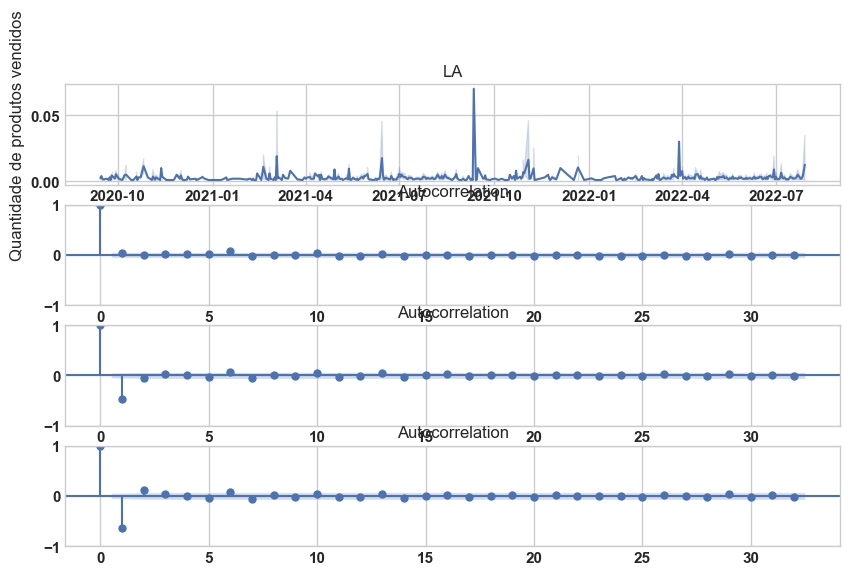

aviamento
Results of Dickey-Fuller Test:
Test Statistic:  -2.3641959917403796
p-value:  0.15209780297137254
Critical Values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Not Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -3.0074392541251824
p-value:  0.03420548384667021
Critical Values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Not Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -1.6808173631743584
p-value:  0.4410220598384494
Critical Values:  {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
Not Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -2.3641959917403796
p-value:  0.15209780297137254
Critical Values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Not Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -3.0074392541251824
p-value:  0.03420548384667021
Critical Values:  {'1%': -3.964443

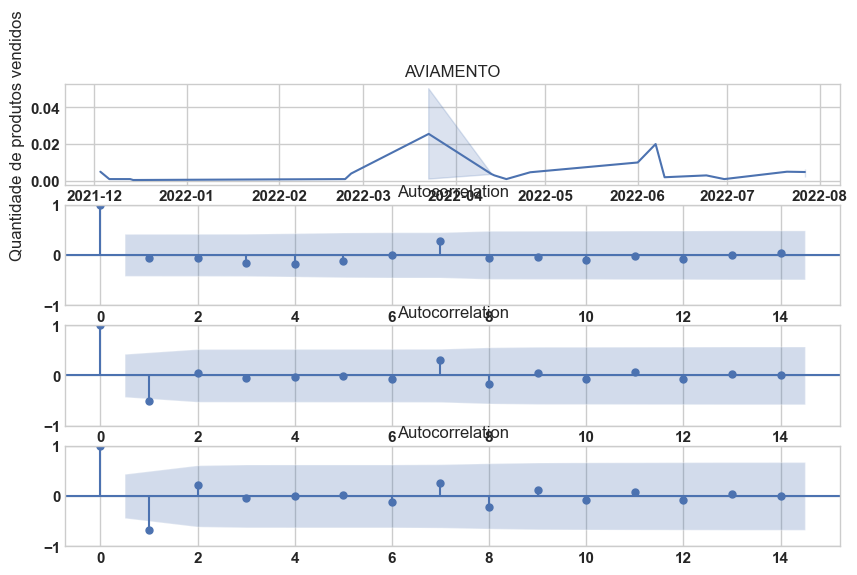

outros
Results of Dickey-Fuller Test:
Test Statistic:  -3.9129641556582597
p-value:  0.001941482788942983
Critical Values:  {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -4.000550976677102
p-value:  0.0014076289239220244
Critical Values:  {'1%': -3.9240193847656246, '5%': -3.0684982031250003, '10%': -2.67389265625}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -2.7320728003029187
p-value:  0.0686508005856017
Critical Values:  {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Not Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -3.9129641556582597
p-value:  0.001941482788942983
Critical Values:  {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}
Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -4.000550976677102
p-value:  0.0014076289239220244
Critical Values:  {'1%': -3.9240193847656246, '5%'

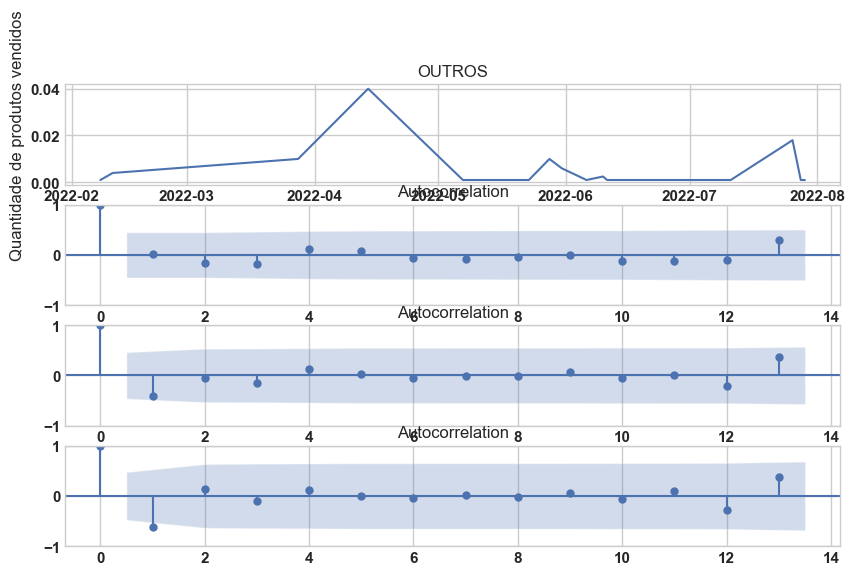

servicos
Results of Dickey-Fuller Test:
Test Statistic:  -2.2957069216845327
p-value:  0.17335631341250357
Critical Values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Not Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -5.0839112744179396
p-value:  1.510175583064571e-05
Critical Values:  {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}
Stationary
Results of Dickey-Fuller Test 3:
Test Statistic:  -5.782449702829833
p-value:  5.088713367026635e-07
Critical Values:  {'1%': -4.068853732362312, '5%': -3.1271488757396453, '10%': -2.7017297633136095}
Stationary
Results of Dickey-Fuller Test:
Test Statistic:  -2.2957069216845327
p-value:  0.17335631341250357
Critical Values:  {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}
Not Stationary
Results of Dickey-Fuller Test 2:
Test Statistic:  -5.0839112744179396
p-value:  1.510175583064571e-05
Critical Values:  {'1%': -4.012033600

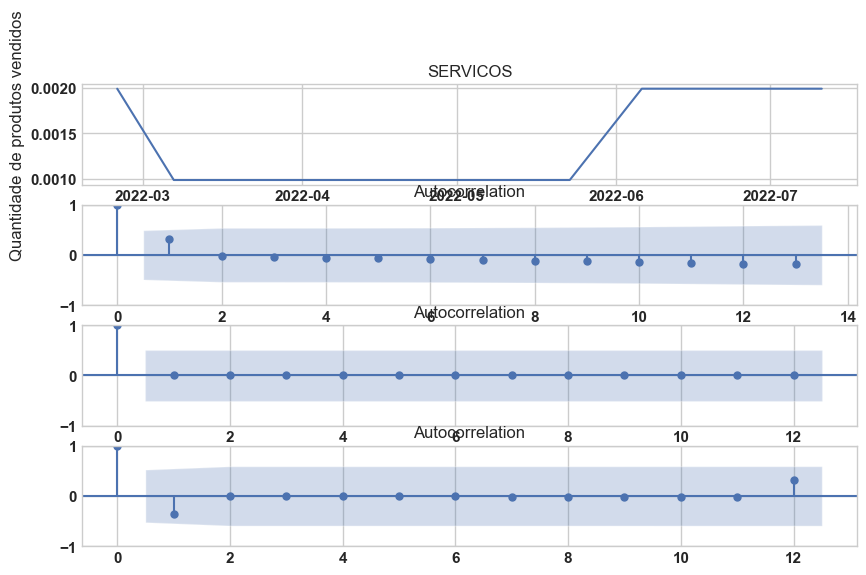

decoracao
categoria decoracao não possui dados suficientes para plotar gráfico
roupas
categoria roupas não possui dados suficientes para plotar gráfico


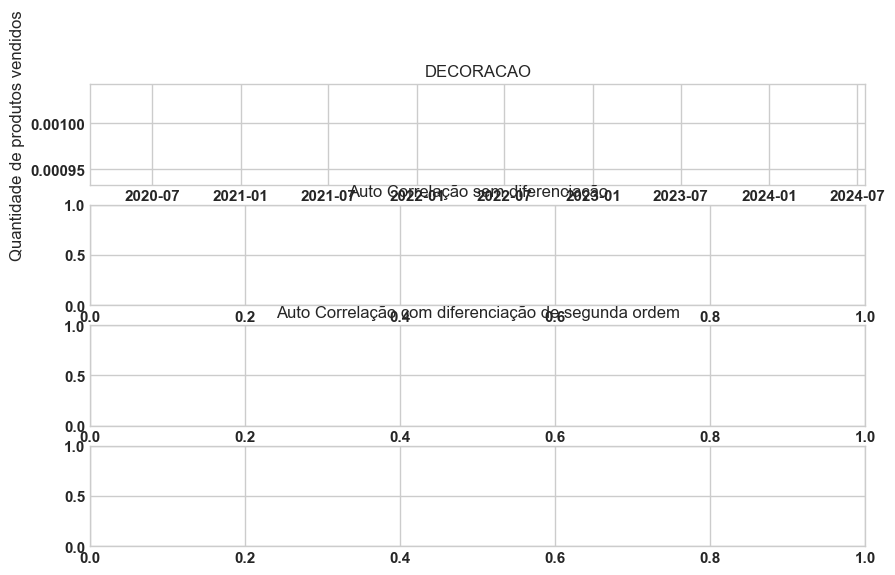

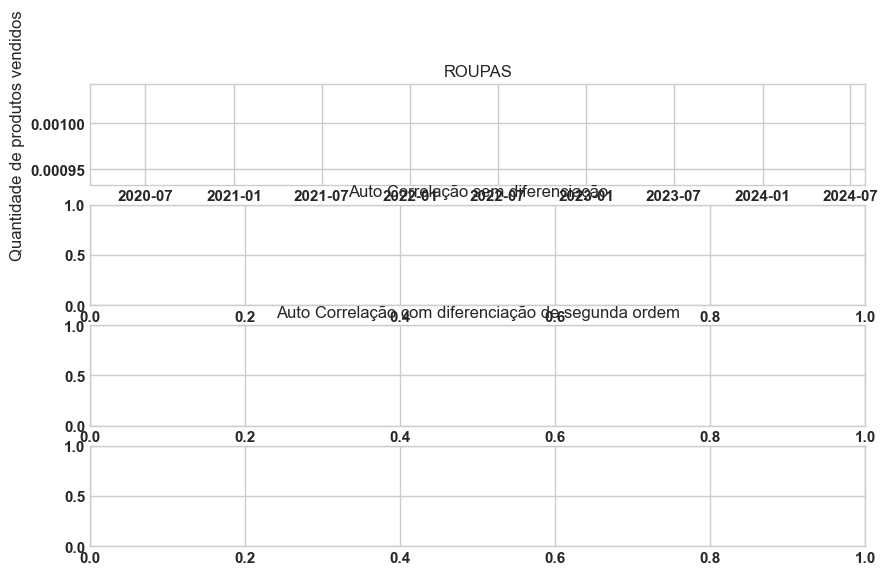

In [27]:
#sns timeplot hue categoria dataframe_transacoes_produto_tratado_2 by venda and data

figure(figsize=(8, 5), dpi=80)
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 45, 'font.weight': 'bold', 'font.family': 'sans-serif', 'font.sans-serif': 'Arial'})
tbl_testes = pd.DataFrame(columns=['categoria','adf','adf2','adf3','pvvalue','pvvalue2','pvvalue3','critical_value','critical_value2','critical_value3'])
tbl_testes_temp = pd.DataFrame(columns=['categoria','adf','adf2','adf3','pvvalue','pvvalue2','pvvalue3','critical_value','critical_value2','critical_value3'])
#create a time plot 
for categoria in modelo_transac_prod_vendas_diario['categoria'].unique():
    modelo_transac_prod_vendas_categoria =modelo_transac_prod_vendas_diario[modelo_transac_prod_vendas_diario['categoria'] == categoria]
    print(categoria)
    try:
        fig,axes = plt.subplots(nrows=4,ncols=1,figsize=(10,6))
        axes[0].set_title('Quantidade de produtos vendidos por categoria')
        axes[0].set_xlabel('Data')
        axes[0].set_ylabel('Quantidade de produtos vendidos')
        axes[0].set_title(categoria.upper())
        axes[1].set_title('Auto Correlação sem diferenciação')
        axes[2].set_title('Auto Correlação com diferenciação de primeira ordem')
        axes[2].set_title('Auto Correlação com diferenciação de segunda ordem')
        sns.lineplot(x='data_dia', y=(modelo_transac_prod_vendas_categoria['qtd_norm']), data=modelo_transac_prod_vendas_diario,ax=axes[0])
       
        plot_acf(modelo_transac_prod_vendas_categoria['quant_'],ax=axes[1])
        
        plot_acf(modelo_transac_prod_vendas_categoria['quant_'].diff().dropna(),ax=axes[2])
 
        plot_acf(modelo_transac_prod_vendas_categoria['quant_'].diff().diff().dropna(),ax=axes[3])
        check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])
        tbl_testes_temp['categoria'] = categoria
        tbl_testes_temp['adf'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[0]
        tbl_testes_temp['adf2'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[1]
        tbl_testes_temp['adf3'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[2]
        tbl_testes_temp['pvvalue'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[3]
        tbl_testes_temp['pvvalue2'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[4]
        tbl_testes_temp['pvvalue3'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[5]
        tbl_testes_temp['critical_value'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[6]
        tbl_testes_temp['critical_value2'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[7]
        tbl_testes_temp['critical_value3'] = check_stationarity(modelo_transac_prod_vendas_categoria['quant_'])[8]


        tbl_testes = tbl_testes.append(tbl_testes_temp)
        
        plt.show()
    except:
        print('categoria {0} não possui dados suficientes para plotar gráfico'.format(categoria))
#       print('Decomposição da série temporal aditiva')
#   decompose = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='additive', period=30)
#   print('Decomposição da série temporal multiplicativa de primeira ordem')
#   decompose2 = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='aditive', period=30)
#   print('Decomposição da série temporal multiplicativa de segunda ordem')
#   decompose3 = seasonal_decompose(modelo_transac_prod_vendas_categoria['quant_'], model='aditive', period=30, extrapolate_trend='freq')


In [28]:
tbl_testes

categoria       adf      adf2      adf3   pvvalue      pvvalue2      pvvalue3 critical_value critical_value2 critical_value3
1%        NaN       NaN       NaN       NaN       NaN           NaN           NaN             1%              1%              1%
5%        NaN       NaN       NaN       NaN       NaN           NaN           NaN             5%              5%              5%
10%       NaN       NaN       NaN       NaN       NaN           NaN           NaN            10%             10%             10%
1%     tecido -4.477912 -8.255435 -8.337064  0.000216  5.252754e-13  3.250810e-13             1%              1%              1%
5%     tecido -4.477912 -8.255435 -8.337064  0.000216  5.252754e-13  3.250810e-13             5%              5%              5%
..        ...       ...       ...       ...       ...           ...           ...            ...             ...             ...
5%     outros -3.912964 -4.000551 -2.732073  0.001941  1.407629e-03  6.865080e-02             5%              5%              5%
10%    outros -3.912964 -4.000551 -2.732073  0.001941  1.407629e-03  6.865080e-02            10%             10%             10%
1%   servicos -2.295707 -5.083911 -5.782450  0.173356  1.510176e-05  5.088713e-07             1%              1%              1%
5%   servicos -2.295707 -5.083911 -5.782450  0.173356  1.510176e-05  5.088713e-07             5%              5%              5%
10%  servicos -2.295707 -5.083911 -5.782450  0.173356  1.510176e-05  5.088713e-07            10%             10%             10%

[33 rows x 10 columns]

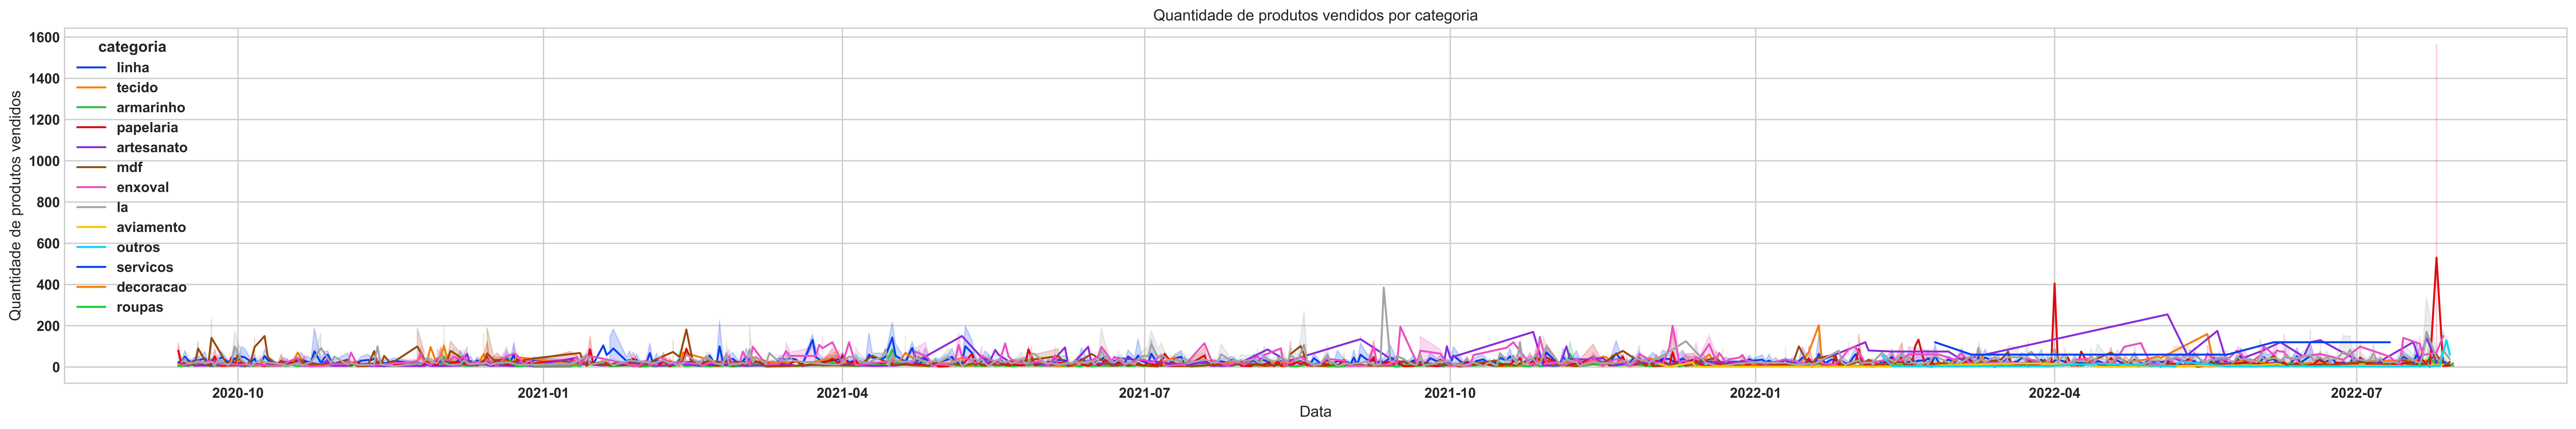

In [29]:
figure(figsize=(35, 5), dpi=600)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,5)
sns.lineplot(x='data_dia', y='total', data=modelo_transac_prod_vendas_diario, hue='categoria', style='categoria',dashes=False, palette='bright', legend='full')
plt.title('Quantidade de produtos vendidos por categoria')
plt.xlabel('Data')
plt.ylabel('Quantidade de produtos vendidos')
plt.show()


Remoção das categorias Roupas, Serviços e Decoração por não conterem dados relevantes ao estudo.

In [30]:
modelo_transac_prod_vendas_diario_ajust = modelo_transac_prod_vendas_diario.query("categoria != 'roupas' & categoria != 'decoracao' & categoria != 'servicos' & categoria != 'outros' ")
modelo_transac_prod_vendas_diario_ajust

numero  categoria    data_dia   ano  mes  mes_ano  quant_  qtd_norm  total
0       11637      linha  2020-09-13  2020    9  2020-09    4.00  0.003988   8.00
15      11654     tecido  2020-09-13  2020    9  2020-09    2.00  0.001988  12.00
14      11651  armarinho  2020-09-13  2020    9  2020-09    4.00  0.003988   0.80
12      11649  armarinho  2020-09-13  2020    9  2020-09    4.00  0.003988   6.00
11      11648  armarinho  2020-09-13  2020    9  2020-09    1.00  0.000988  10.00
...       ...        ...         ...   ...  ...      ...     ...       ...    ...
12156   38237         la  2022-07-29  2022    7  2022-07    1.00  0.000988   6.80
12170   38252  armarinho  2022-07-30  2022    7  2022-07  100.00  0.099989  28.00
12168   38251  armarinho  2022-07-30  2022    7  2022-07    1.00  0.000988   5.80
12169   38251      linha  2022-07-30  2022    7  2022-07    2.00  0.001988   6.00
12171   38253     tecido  2022-07-30  2022    7  2022-07    0.25  0.000238   6.97

[12135 rows x 9 columns]

O Estudo será focado nas 3 categorias mais representativas, sendo por 2 critérios das análises de:
* Volume de Vendas em Valor pelos meses
* Quantidade em venda sendo um fator de desempate
* Maior representavidade de Valor como terceiro 

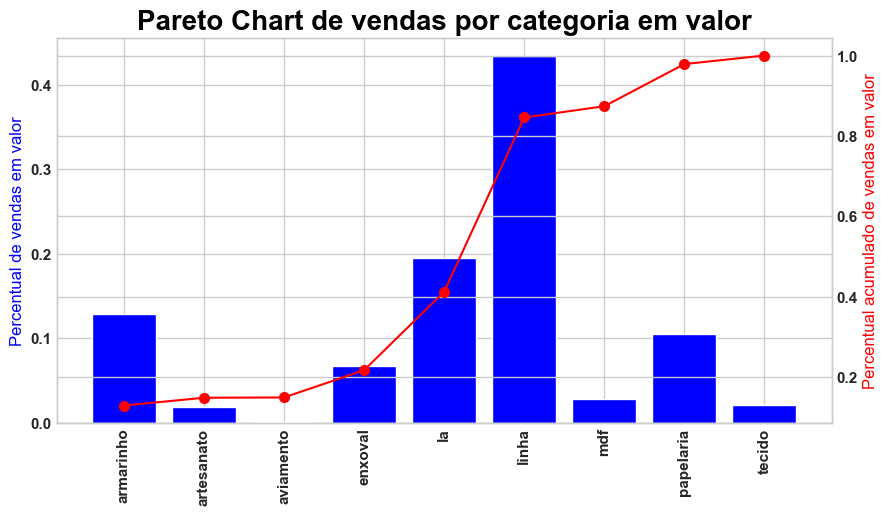

In [31]:
#pareto chart by categoria considering total value and total quantity
df = modelo_transac_prod_vendas_diario_ajust.groupby(['categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
df['total_perc'] = df['total']/df['total'].sum()
df['total_perc_acum'] = df['total_perc'].cumsum()
df

#plot df
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.bar(df['categoria'], df['total_perc'], color='blue')
ax2.plot(df['categoria'], df['total_perc_acum'], color='red', marker='o', ms=7)
ax1.set_xticklabels(df['categoria'], rotation=90)
ax1.set_ylabel('Percentual de vendas em valor', color='blue')
ax2.set_ylabel('Percentual acumulado de vendas em valor', color='red')
plt.title('Pareto Chart de vendas por categoria em valor', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.show()


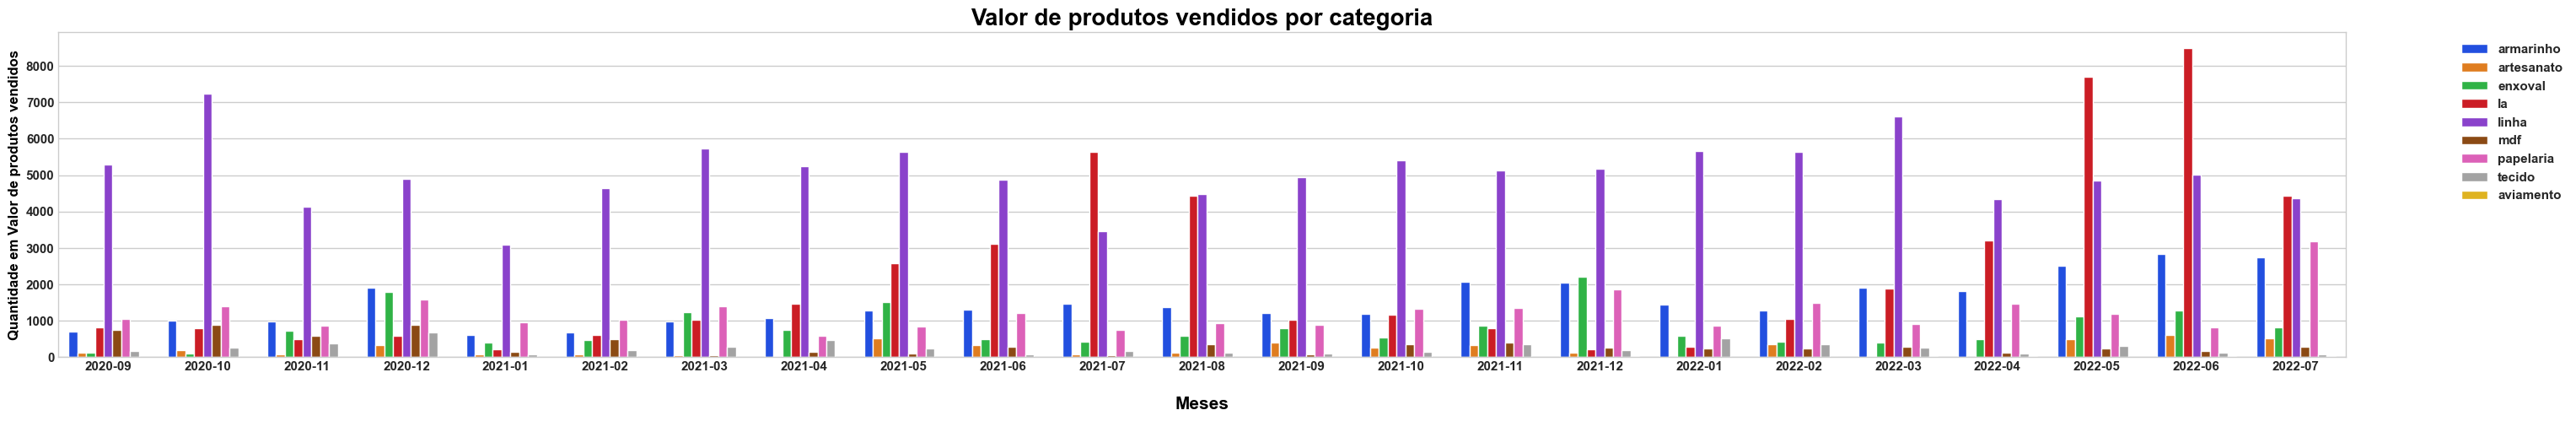

In [32]:

df = modelo_transac_prod_vendas_diario_ajust.groupby(['mes_ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='mes_ano', y='total', data=df, hue='categoria', palette='bright')
plt.title('Valor de produtos vendidos por categoria', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.xlabel('Meses', fontsize=15, fontweight='bold', fontfamily='sans-serif', color='black', labelpad=20)
plt.figsize=(10,12)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylabel('Quantidade em Valor de produtos vendidos', fontsize=12, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.show()

Text(0, 0.5, 'Quantidade em unidades de produtos vendidos')

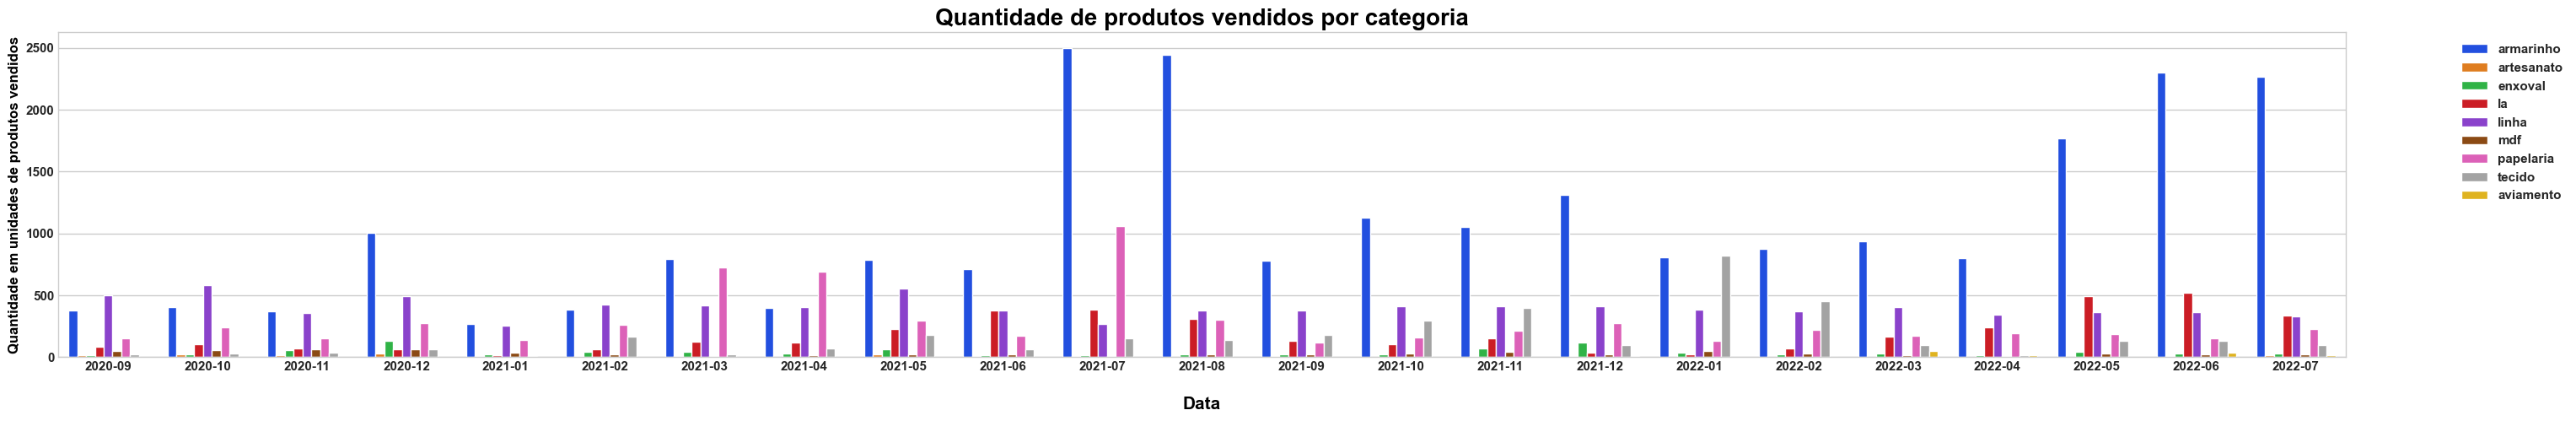

In [33]:
df = modelo_transac_prod_vendas_diario_ajust.groupby(['mes_ano','mes','categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
sns.barplot(x='mes_ano', y='quant_', data=df, hue='categoria', palette='bright')
plt.title('Quantidade de produtos vendidos por categoria', fontsize=20, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')
plt.xlabel('Data', fontsize=15, fontweight='bold', fontfamily='sans-serif', color='black', labelpad=20)
plt.figsize=(10,12)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.ylabel('Quantidade em unidades de produtos vendidos', fontsize=12, fontweight='bold', fontfamily='sans-serif', color='black', loc='center')

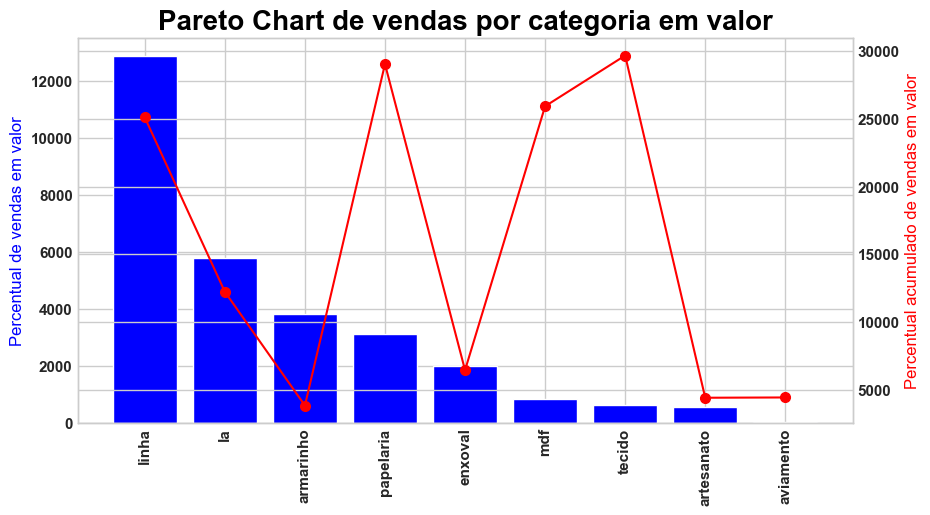

In [47]:
#pareto chart by categoria considering total value and total quantity
df = modelo_transac_prod_vendas_diario_ajust.groupby(['categoria']).agg({'total':'sum'}).reset_index()
df['total_perc'] = df['total']/df['total'].sum()
df['total_perc_acum'] = df['total_perc'].cumsum()
df

#plot df
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.bar(df['categoria'], df['total_perc'], color='blue')

#df1 = modelo_transac_prod_vendas_diario_ajust.groupby(['categoria']).agg({'quant_': 'sum','total':'sum'}).reset_index()
#df1['percentual'] = df1['total']/df1['total'].sum()
#df1['percentual_acumulado'] = df1['percentual'].cumsum()
#df1['percentual_acumulado'] = df1['percentual_acumulado']*100
#df1['percentual'] = df1['percentual']*100
#df1 = df1.sort_values(by=['percentual_acumulado'], ascending=False)


NameError: name 'df1' is not defined

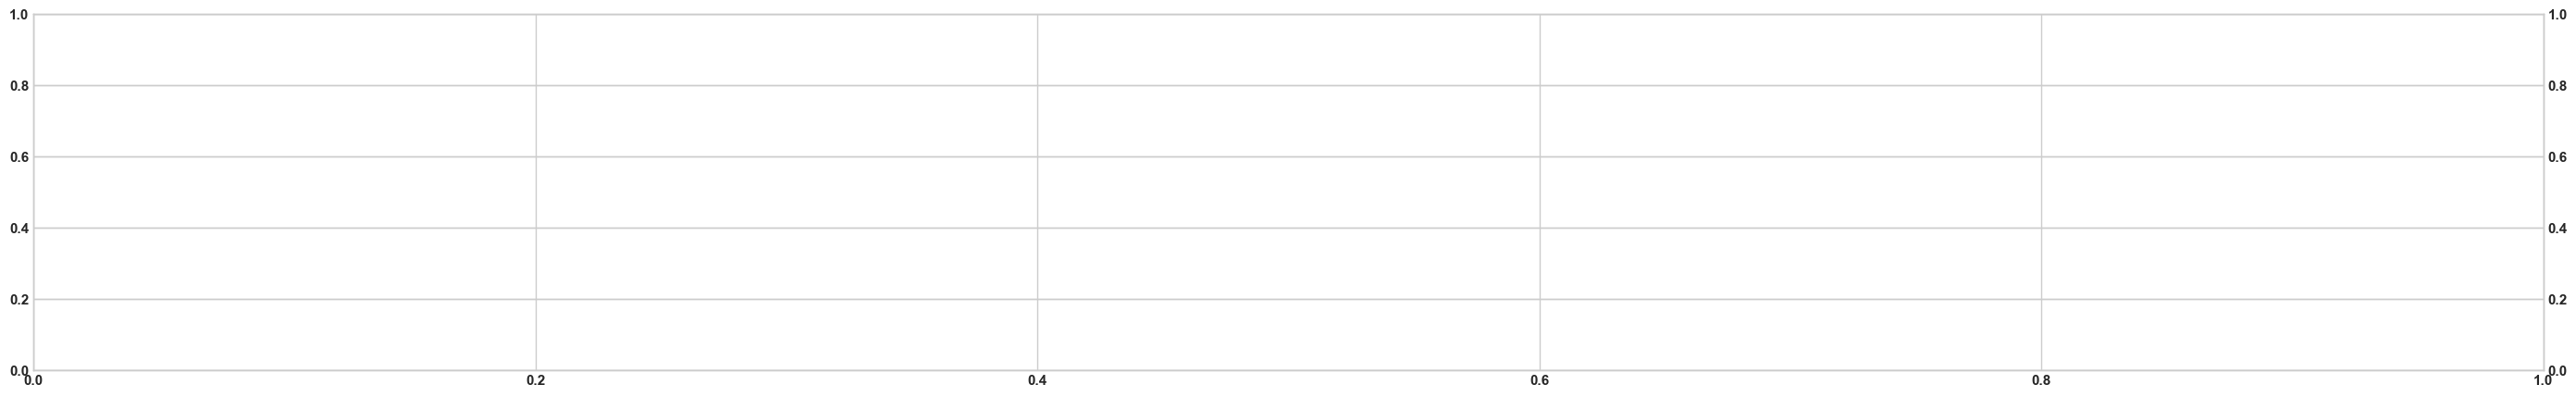

In [35]:
#plot pareto chart
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(df1['categoria'], df1['percentual'], color='b')
ax2.plot(df1['categoria'], df1['percentual_acumulado'], color='r')
ax1.set_xlabel('Categoria')
ax1.set_ylabel('Percentual', color='b')
ax2.set_ylabel('Percentual acumulado', color='r')
plt.title('Pareto chart por categoria')
plt.show()
